## Pre-processing

In [159]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from scipy.stats import linregress

In [160]:
housing = pd.read_csv("../data/housing.txt", sep='\s+')

In [161]:
housing.sample(5)

,Value,Rooms,%Aged,PT-Ratio,%Lower
168,23800,6.3,96,14.7,11.1
362,20800,5.4,96,20.2,10.2
329,22600,6.3,17,16.9,7.3
486,19100,6.1,80,20.2,15.0
493,21800,5.7,54,19.2,12.0


In [162]:
housing.describe()

,Value,Rooms,%Aged,PT-Ratio,%Lower
count,506.000000,506.000000,506.000000,506.000000,504.000000
mean,22532.806324,6.238142,68.616601,18.455534,12.672817
std,9197.104087,1.042763,28.138400,2.164946,7.148724
min,5000.000000,-6.200000,3.000000,12.600000,1.700000
25%,17025.000000,5.900000,45.000000,17.400000,6.975000
50%,21200.000000,6.200000,77.500000,19.050000,11.350000
75%,25000.000000,6.600000,94.000000,20.200000,17.025000
max,50000.000000,8.800000,100.000000,22.000000,38.000000


In [163]:
housing.isna().sum()

Value       0
Rooms       0
%Aged       0
PT-Ratio    0
%Lower      2
dtype: int64

We can verify that there are 2 missing values in the "%Lower" variable.

In [164]:
housing[housing['%Lower'].isnull()]

,Value,Rooms,%Aged,PT-Ratio,%Lower
36,20000,5.8,61,19.2,NaN
250,24400,6.5,13,19.1,NaN


For row 36, we may replace the "NaN" with its mean, because other variables of the same row are close to their means. It's harder to assign a replacement for row 250, as the "%Aged" variable is far away from its mean, while other variables are closer to theirs. However, this way of thinking assumes linear relationships amongst the variables, which may or may not be the case. Given the small number of missing values (2 out of 506), it may be best to simply drop them, as their impact on the dataset is more likely to be minimal.

In [165]:
housing.dropna().describe()

,Value,Rooms,%Aged,PT-Ratio,%Lower
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,22534.126984,6.238492,68.742063,18.452778,12.672817
std,9214.302244,1.044586,28.082684,2.168799,7.148724
min,5000.000000,-6.200000,3.000000,12.600000,1.700000
25%,16950.000000,5.900000,45.000000,17.375000,6.975000
50%,21200.000000,6.200000,78.000000,19.000000,11.350000
75%,25000.000000,6.600000,94.000000,20.200000,17.025000
max,50000.000000,8.800000,100.000000,22.000000,38.000000


We can verify dropping the two rows with missing values does not change much of the summary statistics.

In [166]:
housing_no_missing = housing.dropna()
housing_no_missing[housing_no_missing.Rooms < 0]

,Value,Rooms,%Aged,PT-Ratio,%Lower
15,19900,-5.8,57,21.0,8.5
83,22900,-6.2,47,19.0,7.5


Another issue with the data is the negative values in the "Rooms" variable, which represents the "(a)verage number of rooms per dwelling". The number of rooms obviously cannot be negative. It looks more likely a case of mistaken records: the negative sign was probably added by accident. So we change both values to their positive counterparts.

In [167]:
neg_index = housing_no_missing.Rooms < 0

housing_no_neg = housing_no_missing.drop(housing_no_missing[neg_index].index)

housing_neg_to_posi = housing_no_missing[neg_index].assign(
    Rooms = lambda df:df.Rooms.abs()
)

h = housing_neg_to_posi.append(housing_no_neg).sort_index()

Here, we replace the negative values with their positive counterparts.

In [168]:
h.loc[neg_index]

,Value,Rooms,%Aged,PT-Ratio,%Lower
15,19900,5.8,57,21.0,8.5
83,22900,6.2,47,19.0,7.5


In [169]:
sum(h.Rooms < 0)

0

We can verify they are now both positive and there is no negative values in "Rooms". To be sure, we take another look at the summary statistics.

In [170]:
h.describe()

,Value,Rooms,%Aged,PT-Ratio,%Lower
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,22534.126984,6.286111,68.742063,18.452778,12.672817
std,9214.302244,0.702541,28.082684,2.168799,7.148724
min,5000.000000,3.600000,3.000000,12.600000,1.700000
25%,16950.000000,5.900000,45.000000,17.375000,6.975000
50%,21200.000000,6.200000,78.000000,19.000000,11.350000
75%,25000.000000,6.600000,94.000000,20.200000,17.025000
max,50000.000000,8.800000,100.000000,22.000000,38.000000


The numbers seem to be reasonable now.

## Analysis

In [171]:
def get_linreg(var1, var2):
    var1_mean = var1.mean()
    var2_mean = var2.mean()

    sum1 = 0
    sum2 = 0
    sum3 = 0

    for i in var1.index:
        sum1 += (var1[i] - var1_mean) * (var2[i] - var2_mean)
        sum2 += (var1[i] - var1_mean) ** 2
        sum3 += (var2[i] - var2_mean) ** 2
    coef = sum1 / (sqrt(sum2) * sqrt(sum3))

    slope = sum1 / sum2

    intercept = var2_mean - slope * var1_mean

    return coef, slope, intercept

In [172]:
l1 = pd.DataFrame(get_linreg(h['Rooms'], h['Value'])).T
l2 = pd.DataFrame(get_linreg(h['%Aged'], h['Value'])).T
l3 = pd.DataFrame(get_linreg(h['PT-Ratio'], h['Value'])).T
l4 = pd.DataFrame(get_linreg(h['%Lower'], h['Value'])).T

lns = pd.concat([l1,l2,l3,l4], ignore_index=True)
lns.columns = ['p-coef', 'slope', 'intercept']
lns.index = ["Rooms-Value", "%Aged-Value", "PT-Ratio-Value", "%Lower-Value"]
lns

,p-coef,slope,intercept
Rooms-Value,0.696273,9132.093458,-34871.227172
%Aged-Value,-0.377768,-123.950816,31054.761840
PT-Ratio-Value,-0.507882,-2157.773660,62351.044831
%Lower-Value,-0.737981,-951.216347,34588.718119


## Visualization

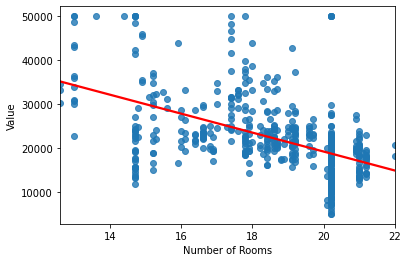

In [181]:
s_t = sns.regplot(x=h['PT-Ratio'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_t.set(xlabel="Number of Rooms")
plt.show()

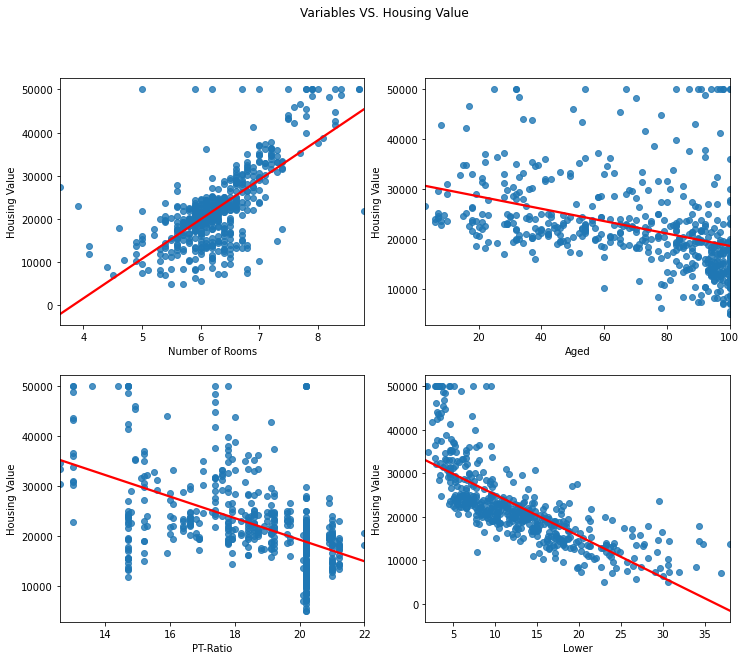

In [196]:
plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)

s_rv = sns.regplot(x=h['Rooms'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_rv.set(xlabel="Number of Rooms", ylabel="Housing Value")

plt.subplot(2, 2, 2)

s_av = sns.regplot(x=h['%Aged'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_av.set(xlabel="Aged", ylabel="Housing Value")

plt.subplot(2, 2, 3)

s_pv = sns.regplot(x=h['PT-Ratio'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_pv.set(xlabel="PT-Ratio", ylabel="Housing Value")

plt.subplot(2, 2, 4)

s_lv = sns.regplot(x=h['%Lower'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_lv.set(xlabel="Lower", ylabel="Housing Value")

plt.suptitle("Variables VS. Housing Value")
plt.show()